In [55]:
import joblib
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50
pd.set_option('display.max_colwidth', 120)

In [56]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred);
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [4]:
tableToRead = 'maint_order' # maint_order maint_req
columnToClassify = 'priority'

In [5]:
df_table_full = pd.read_csv("./base_manusis/preprocess_slim/"+tableToRead+"_etl.csv",low_memory=False)

In [6]:
df_backup = df_table_full.copy()

In [7]:
df_table_full.groupby('priority').count()[['area_id']]

,area_id
priority,
1,141982
2,19733
3,17652
4,9092
5,4546


In [8]:
min_value = min(list(df_table_full.groupby(['priority']).size()))

In [9]:
priority_values = list(df_table_full.priority.unique())

In [10]:
list_df = []
for i in priority_values:
    df_aux = df_table_full.query(f"priority=={str(i)}")
    df_aux = df_aux.sample(frac=1).reset_index(drop=True)
    df_aux = df_aux[:min_value]
    list_df.append(df_aux)

In [11]:
for t in list_df:
    print(t.shape)

(4546, 12)
(4546, 12)
(4546, 12)
(4546, 12)
(4546, 12)


In [25]:
df_table = pd.concat(list_df)

In [13]:
df_table = df_table_full

In [26]:
df_table.shape

(22730, 12)

In [27]:
print(df_table[columnToClassify].unique())
print(df_table.shape)

[1 3 5 2 4]
(22730, 12)


In [28]:
previsores = df_table.drop(columnToClassify, axis=1)
classe = df_table[[columnToClassify]]

previsores_names = list(df_table.drop(columnToClassify, axis=1).columns)
class_names = df_table[columnToClassify].unique().astype(str)

In [29]:
_,cols = previsores.shape

# Transforma features em códigos

In [30]:
from sklearn.preprocessing import LabelEncoder

labelencoder_previsores = LabelEncoder()
for i in previsores.columns:
    previsores[i] = labelencoder_previsores.fit_transform(previsores[i])

labelencoder_classe = LabelEncoder()
classe[columnToClassify] = labelencoder_classe.fit_transform(classe[columnToClassify])

/home/gregory/anaconda3/envs/pibiti/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
previsores.shape

(22730, 11)

In [32]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# previsores = scaler.fit_transform(previsores)

In [33]:
from sklearn.model_selection import train_test_split

previsores_train, previsores_test, classe_train, classe_test = train_test_split(previsores, 
                                                                                classe,
                                                                                test_size=0.30,
                                                                                random_state=0)

In [71]:
# from sklearn.naive_bayes import GaussianNB
# classificador = GaussianNB()

# from sklearn.tree import DecisionTreeClassifier, export
# classificador = DecisionTreeClassifier(criterion='entropy')

from sklearn.svm import SVC
classificador = SVC(kernel='rbf',random_state=1,gamma='auto')

# from sklearn.neighbors import KNeighborsClassifier
# classificador = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=4)

# from sklearn.neural_network import MLPClassifier
# classificador = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

classificador.fit(previsores_train,classe_train)
previsoes = classificador.predict(previsores_test)

/home/gregory/anaconda3/envs/pibiti/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [72]:
from sklearn.metrics import confusion_matrix, accuracy_score

precisao = accuracy_score(classe_test,previsoes)
matriz = confusion_matrix(classe_test,previsoes)

print('precision:', precisao)

precision: 0.5599061445959819


Normalized confusion matrix


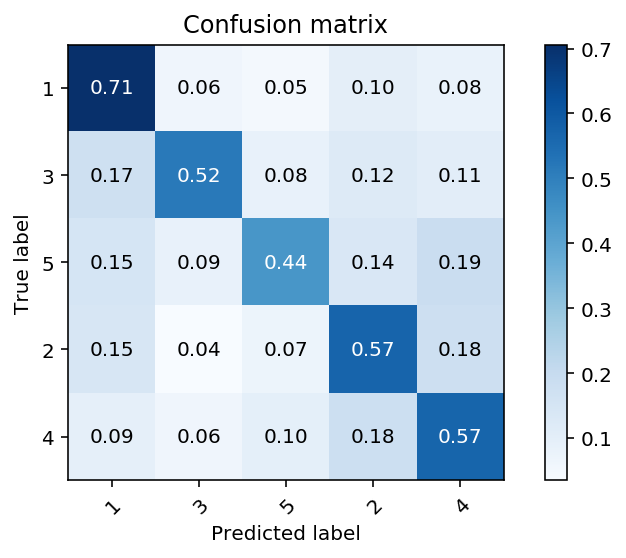

In [73]:
%config InlineBackend.figure_format ='retina'
np.set_printoptions(precision=4)
# Plot non-normalized confusion matrix
plot_confusion_matrix(classe_test, previsoes, classes=class_names,normalize=True,title='Confusion matrix' )

# Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
#Create a Gaussian Classifier
rfc=RandomForestClassifier(n_estimators=10);
#Train the model using the training sets y_pred=clf.predict(X_test)
rfc.fit(previsores_train,classe_train);
# y_pred=rfc.predict(X_test)

/home/gregory/anaconda3/envs/pibiti/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [41]:
feature_imp = pd.Series(rfc.feature_importances_,index=previsores_names).sort_values(ascending=False);

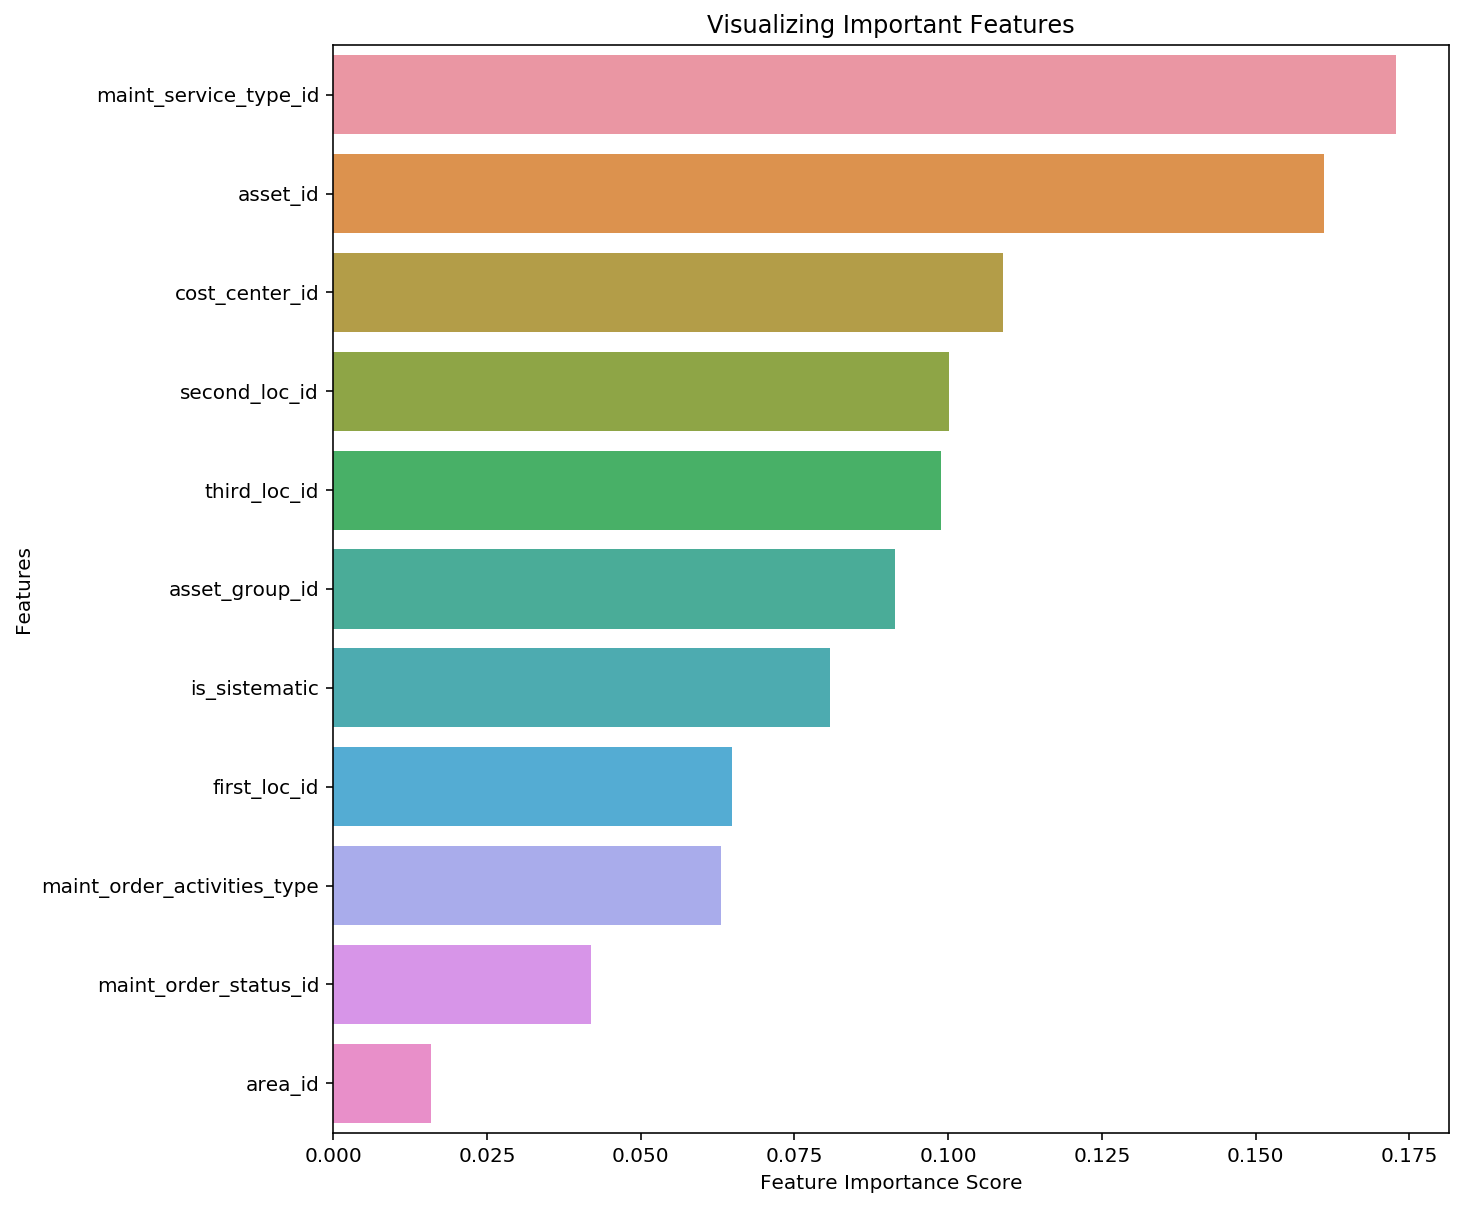

In [42]:
plt.rcParams['figure.figsize']=(10,10)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# OLD START

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# onehotencoder = OneHotEncoder(categorical_features=[3])
# previsores_test = onehotencoder.fit_transform(previsores).toarray()

# cols_onehot = []
# for i in range(0,cols):
#     if len(np.unique(previsores[:, i]))>2 :
#         cols_onehot.append(i)

# onehotencoder = OneHotEncoder(categorical_features=cols_onehot,sparse=False)
# previsores = onehotencoder.fit_transform(previsores).toarray()

# OLD END

# Parse TXT

In [ ]:
import os
import re
import pandas as pd

path = "./base_manusis/evaluation/records_validate.txt"

with open(path, 'r', encoding="UTF-16", errors='ignore') as f:
    contents = f.readlines()

test_list = []

for data in contents:
    if len(re.findall(r'\{([^]]+)\}',data)) > 0:
        pass
    elif 'description' in data:
        pass
    else:
        if ':' in data:
            aux_spl = data.split(':')
            
            aux_spl_2 = ':'.join(aux_spl[1:])
            aux_spl_2 = aux_spl_2.replace("\n",",\n")
            
            text = f'"{aux_spl[0]}":{aux_spl_2}'
            test_list.append(text)
        else:
            test_list.append(data)
            
json_result = ''.join(test_list)
json_result = json_result.replace(',\n}','\n}')
json_result = "["+json_result+"]"
json_result = json_result.replace('null','None')
json_result = json_result.replace('false','False')
json_result = json_result.replace('true','True')

# with open("./base_manusis/evaluation/records_etl.json",'w') as f:
#     f.writelines(json_result)
    
# with open('./base_manusis/evaluation/records_etl.json', 'r', errors='ignore') as f:
#     contents2 = f.read()

json_list = eval(json_result)

# Test JSON Modelo

In [ ]:
df_eval = pd.DataFrame(json_list)
df_eval = df_eval[df_table.columns]

def correc(x):
    if x in [None,False,np.NaN]:
        return 0
    elif x in [True]:
        return 1
    else:
        return x

for col in df_table.columns:
    df_eval[col] = df_eval[col].apply(correc)
    
df_eval.head()

In [ ]:
previsores_eval = df_eval.drop(columnToClassify, axis=1)
classe_eval = df_eval[[columnToClassify]]

previsores_names_eval = list(df_eval.drop(columnToClassify, axis=1).columns)
class_names_eval = df_eval[columnToClassify].unique().astype(str)

In [ ]:
_,cols = previsores_eval.shape

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelencoder_previsores = LabelEncoder()
for i in previsores_eval.columns:
    previsores_eval[i] = labelencoder_previsores.fit_transform(previsores_eval[i])

labelencoder_classe = LabelEncoder()
classe_eval[columnToClassify] = labelencoder_classe.fit_transform(classe_eval[columnToClassify])

In [ ]:
previsoes_eval = classificador.predict(previsores_eval)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

precisao_eval = accuracy_score(classe_eval,previsoes_eval)
matriz_eval = confusion_matrix(classe_eval,previsoes_eval)

print('precision:', precisao_eval)

# With CSV Evaluation

In [43]:
import pandas as pd

pathFile = './base_manusis/evaluation/maint_order.csv'

df_eval = pd.read_csv(pathFile, delimiter=';')

print('before',df_eval.shape)

df_eval = df_eval[df_table.columns]

print('after',df_eval.shape)

df_eval = df_eval.fillna(0)

before (100, 118)
after (100, 12)


In [81]:
df_eval.groupby('priority').count()[['area_id']]

,area_id
priority,
1,56
2,32
3,12


In [44]:
df_eval.loc[[1]]

,asset_id,third_loc_id,second_loc_id,cost_center_id,asset_group_id,first_loc_id,area_id,maint_service_type_id,maint_order_activities_type,is_sistematic,priority,maint_order_status_id
1,32897,3486,3057,283,2536,2969,17,4,1,0,1,3


In [45]:
previsores_eval = df_eval.drop(columnToClassify, axis=1)
classe_eval = df_eval[[columnToClassify]]

previsores_names_eval = list(df_eval.drop(columnToClassify, axis=1).columns)
class_names_eval = df_eval[columnToClassify].unique().astype(str)

In [46]:
_,cols = previsores_eval.shape

In [47]:
from sklearn.preprocessing import LabelEncoder

labelencoder_previsores = LabelEncoder()
for i in previsores_eval.columns:
    previsores_eval[i] = labelencoder_previsores.fit_transform(previsores_eval[i])

labelencoder_classe = LabelEncoder()
classe_eval[columnToClassify] = labelencoder_classe.fit_transform(classe_eval[columnToClassify])

/home/gregory/anaconda3/envs/pibiti/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [74]:
previsoes_eval = classificador.predict(previsores_eval)

In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score

precisao_eval = accuracy_score(classe_eval,previsoes_eval)
matriz_eval = confusion_matrix(classe_eval,previsoes_eval)

print('precision:', precisao_eval)

precision: 0.56


In [76]:
matriz_eval

array([[56,  0,  0],
       [32,  0,  0],
       [12,  0,  0]])

In [77]:
classe_eval.priority.unique()

array([0, 1, 2])

In [78]:
set(previsoes_eval)

{0}